In [1]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
PATH = '/home/kai/data/kaggle/homecredit/'



In [2]:
train = pd.read_pickle(PATH + 'test/train_ori.pkl')
test = pd.read_pickle(PATH + 'test/test_ori.pkl')
# train = pd.read_pickle(PATH + 'test/train_w_prev_2.pkl')
# test = pd.read_pickle(PATH + 'test/test_w_prev_2.pkl')

print(train.shape,test.shape)
train.shape, test.shape
prev = pd.read_pickle(PATH + 'test/prev2curr_0.pkl')
print(prev.shape)
pos = pd.read_pickle(PATH +'test/pos/all_agg.pkl')
print(pos.shape)
cred = pd.read_pickle(PATH + 'inter/credit2curr.pkl')
print(cred.shape)
install = pd.read_pickle(PATH + 'inter/old_inst2curr.pkl')
print(install.shape)
bureau = pd.read_pickle(PATH + 'inter/bureau2curr.pkl')
print(bureau.shape)

(307511, 329) (48744, 328)
(356255, 818)
(356255, 137)
(356255, 502)
(356255, 60)
(356255, 554)


In [3]:
files = [prev,pos,cred,install,bureau]
# files = [prev,cred,install,bureau]
# files = [prev,pos,install,bureau]
# files = [pos,cred,install,bureau]
for tmp in files:
#     cols = [col for col in tmp.columns if 'std' not in col]
#     tmp = tmp[cols]
#     print(tmp.shape)
    train = train.merge(tmp, on='SK_ID_CURR', how='left')
    test = test.merge(tmp, on='SK_ID_CURR', how='left')
    print(train.shape,test.shape)
    


(307511, 1146) (48744, 1145)
(307511, 1282) (48744, 1281)
(307511, 1783) (48744, 1782)
(307511, 1842) (48744, 1841)
(307511, 2395) (48744, 2394)


In [4]:
print(train.shape, test.shape)

(307511, 2395) (48744, 2394)


In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
PATH = '/home/kai/data/kaggle/homecredit/'
print('begin cv')
target = train['TARGET']
test_df = test.copy()
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR']
features = [x for x in train.columns if x not in ignore_cols]
train = train[features]
test = test[features]

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train,
                          label=target,

                          categorical_feature=[],#categorical_feats,
                          free_raw_data=False)

# lgbm_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
#           'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 4000, 'verbose': 0 ,
#           'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
#           'min_split_gain':.01, 'min_child_weight':1,'num_threads': 12,'feature_fraction': 0.2,
#               'scale_pos_weight':1}
# lgbm_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'auc',
#     'learning_rate': 0.05,
#     'num_iteration': 4000,
#     'num_threads': 8,

#     'num_leaves': int(round(44.368535336628419)),
#     'feature_fraction': 0.28231763168020257,
#     'bagging_fraction': 0.94901525271474951,
#     'max_depth': int(round(8.0430115561596267)),
#     'lambda_l1': 0.30680079516647751,
#     'lambda_l2': 0.079128660903201031,
#     'min_split_gain': 0.054005067457890979,
#     'min_child_weight': 98.172643147364937}
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.02,
    'num_iteration': 4000,
    'num_threads': 8,

    'num_leaves': int(round(44.368535336628419)),
    'feature_fraction': 0.15,
    'bagging_fraction': 0.94901525271474951,
    'max_depth': int(round(8.0430115561596267)),
    'lambda_l1': 0.30680079516647751,
    'lambda_l2': 0.079128660903201031,
    'min_split_gain': 0.054005067457890979,
    'min_child_weight': 15.172643147364937}


cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     early_stopping_rounds=150,
                     verbose_eval=100,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds,
                verbose_eval=100)

""" Predict on test set and create submission """
y_pred = clf.predict(test)
out_df = pd.DataFrame({'SK_ID_CURR': test_df['SK_ID_CURR'], 'TARGET': y_pred})
#     small_len = out_df[out_df['TARGET']< threshold1]
#     large_len = out_df[out_df['TARGET']> threshold2]
#     print('length of small and large,',len(small_len),len(large_len))
print((out_df['TARGET']>0.5).sum(),'more than half')



begin cv


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's auc: 0.761279 + 0.00336603
[200]	cv_agg's auc: 0.77363 + 0.00278012
[300]	cv_agg's auc: 0.782606 + 0.00269742
[400]	cv_agg's auc: 0.787647 + 0.00262401
[500]	cv_agg's auc: 0.790502 + 0.00240743
[600]	cv_agg's auc: 0.792433 + 0.00223408
[700]	cv_agg's auc: 0.79367 + 0.00223838
[800]	cv_agg's auc: 0.794572 + 0.00220899
[900]	cv_agg's auc: 0.795125 + 0.00211476
[1000]	cv_agg's auc: 0.795581 + 0.00218749
[1100]	cv_agg's auc: 0.795764 + 0.00210343
[1200]	cv_agg's auc: 0.795837 + 0.00201961
[1300]	cv_agg's auc: 0.796017 + 0.00198905
[1400]	cv_agg's auc: 0.796035 + 0.00194835
[1500]	cv_agg's auc: 0.795985 + 0.0019969
Optimum boost rounds = 1407
Best CV result = 0.7960597695596988


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


191 more than half


New baseline
-----
begin cv
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[100]	cv_agg's auc: 0.761279 + 0.00336603
[200]	cv_agg's auc: 0.77363 + 0.00278012
[300]	cv_agg's auc: 0.782606 + 0.00269742
[400]	cv_agg's auc: 0.787647 + 0.00262401
[500]	cv_agg's auc: 0.790502 + 0.00240743
[600]	cv_agg's auc: 0.792433 + 0.00223408
[700]	cv_agg's auc: 0.79367 + 0.00223838
[800]	cv_agg's auc: 0.794572 + 0.00220899
[900]	cv_agg's auc: 0.795125 + 0.00211476
[1000]	cv_agg's auc: 0.795581 + 0.00218749
[1100]	cv_agg's auc: 0.795764 + 0.00210343
[1200]	cv_agg's auc: 0.795837 + 0.00201961
[1300]	cv_agg's auc: 0.796017 + 0.00198905
[1400]	cv_agg's auc: 0.796035 + 0.00194835
[1500]	cv_agg's auc: 0.795985 + 0.0019969
Optimum boost rounds = 1407
Best CV result = 0.7960597695596988
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.02,
    'num_iteration': 4000,
    'num_threads': 8,

    'num_leaves': int(round(44.368535336628419)),
    'feature_fraction': 0.15,
    'bagging_fraction': 0.94901525271474951,
    'max_depth': int(round(8.0430115561596267)),
    'lambda_l1': 0.30680079516647751,
    'lambda_l2': 0.079128660903201031,
    'min_split_gain': 0.054005067457890979,
    'min_child_weight': 15.172643147364937}

bayes para pos_new with 24, 60 & install test
-----
[100]	cv_agg's auc: 0.780129 + 0.00283542
[200]	cv_agg's auc: 0.788692 + 0.00258271

bayes para pos_new with 24, 60
--------
[100]	cv_agg's auc: 0.779969 + 0.00297851

baye paras/train with modified prev"
----------
begin cv
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[100]	cv_agg's auc: 0.780408 + 0.00290047
[200]	cv_agg's auc: 0.789804 + 0.00263968
[300]	cv_agg's auc: 0.792796 + 0.00252429
[400]	cv_agg's auc: 0.79391 + 0.00252326
[500]	cv_agg's auc: 0.794314 + 0.00242975
[600]	cv_agg's auc: 0.794392 + 0.00237447
[700]	cv_agg's auc: 0.794313 + 0.00234948
Optimum boost rounds = 617
Best CV result = 0.7944380747322322

without std bayes para, 7788 (train with prev)
with std bayes para, 7789 (train without prev)

baseline bayes para, train only pre+: 
    [100]	cv_agg's auc: 0.780408 + 0.00290047
[200]	cv_agg's auc: 0.789804 + 0.00263968
[300]	cv_agg's auc: 0.792796 + 0.00252429

In [6]:
(out_df['TARGET']>0.5).sum()
out_df.to_csv(PATH+'submission/06_29_0.csv', index = False)

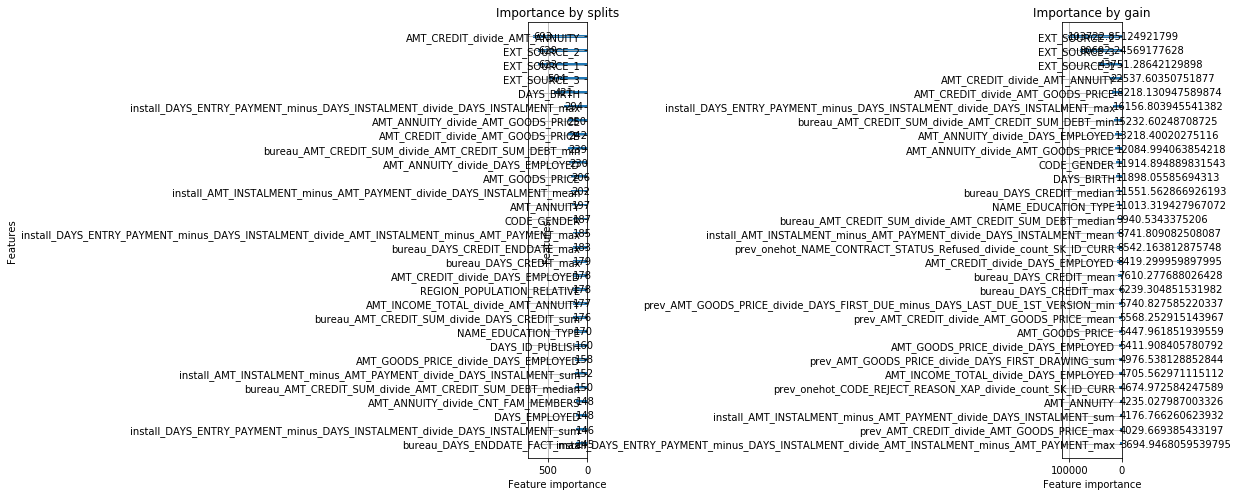

[(0, ('EXT_SOURCE_2', 103722.85124921799)),
 (1, ('EXT_SOURCE_3', 80692.24569177628)),
 (2, ('EXT_SOURCE_1', 43751.28642129898)),
 (3, ('AMT_CREDIT_divide_AMT_ANNUITY', 22537.60350751877)),
 (4, ('AMT_CREDIT_divide_AMT_GOODS_PRICE', 18218.130947589874)),
 (5,
  ('install_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_DAYS_INSTALMENT_max',
   16156.803945541382)),
 (6,
  ('bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_min', 15232.60248708725)),
 (7, ('AMT_ANNUITY_divide_DAYS_EMPLOYED', 13218.40020275116)),
 (8, ('AMT_ANNUITY_divide_AMT_GOODS_PRICE', 12084.994063854218)),
 (9, ('CODE_GENDER', 11914.894889831543)),
 (10, ('DAYS_BIRTH', 11898.05585694313)),
 (11, ('bureau_DAYS_CREDIT_median', 11551.562866926193)),
 (12, ('NAME_EDUCATION_TYPE', 11013.319427967072)),
 (13,
  ('bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_median',
   9940.5343375206)),
 (14,
  ('install_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT_mean',
   8741.809082508087)),
 (15,
  ('prev_onehot_NAME_CO

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=30, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=30, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

x = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x


In [8]:

x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x

[(0, ('AMT_CREDIT_divide_AMT_ANNUITY', 693)),
 (1, ('EXT_SOURCE_2', 629)),
 (2, ('EXT_SOURCE_1', 623)),
 (3, ('EXT_SOURCE_3', 504)),
 (4, ('DAYS_BIRTH', 421)),
 (5,
  ('install_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_DAYS_INSTALMENT_max',
   294)),
 (6, ('AMT_ANNUITY_divide_AMT_GOODS_PRICE', 250)),
 (7, ('AMT_CREDIT_divide_AMT_GOODS_PRICE', 242)),
 (8, ('bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_min', 239)),
 (9, ('AMT_ANNUITY_divide_DAYS_EMPLOYED', 230)),
 (10, ('AMT_GOODS_PRICE', 206)),
 (11,
  ('install_AMT_INSTALMENT_minus_AMT_PAYMENT_divide_DAYS_INSTALMENT_mean',
   202)),
 (12, ('AMT_ANNUITY', 197)),
 (13, ('CODE_GENDER', 187)),
 (14,
  ('install_DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_AMT_INSTALMENT_minus_AMT_PAYMENT_max',
   185)),
 (15, ('bureau_DAYS_CREDIT_ENDDATE_max', 183)),
 (16, ('bureau_DAYS_CREDIT_max', 179)),
 (17, ('REGION_POPULATION_RELATIVE', 178)),
 (18, ('AMT_CREDIT_divide_DAYS_EMPLOYED', 178)),
 (19, ('AMT_INCOME_TOTAL_divide_AMT_ANNUITY', 